This notebook is intended to provide an overview of the Mamajek Stellar Analysis Automation Tool. Below you will find descriptions, documentation, and examples of all capabilities of the program. The primary purpose of this program is to estimate spectral type using temperature and magnitude data, with Eric Mamajek's "Stellar Color and Effective Temperature Sequence" table acting as reference.

The program can be run on one system at a time, using manual input ("single set"), or on a file containing a list of inputs ("file set").

---

The program is comprised of four individual data return modules, corresponding to four different categories of data—position, magnitude, temperature, and spectral type—and one combined module. 

The temperature, spectral type, and combined modules each have two scripts, one intended for use on single sets, the other for use on file sets.

---

Below are the necessary import statements.

In [2]:
from position import position
from magnitude import magnitude
from teff import get_teff
from teff_file import teff_file
from spectral import spectral_type
from spectral_file import spectral_file
from mamajek_table_lookup import mamajek_table_lookup
from mamajek_table_lookupfile import mamajek_table_lookupfile

**POSITION**

The `position` function takes the centroid positions of the primary and companion star, measured in pixels, and converts them to an angular separation and position angle. The function requires the additional input of a pixel scale and mirroring flag. Because the night sky uses a left-handed coordinate system, but some telescopes return right-handed imaging results, a multiplier of 1 (``"noxflip"``) or –1 (``"xflip"``) is needed to determine whether to reflect the pixel coordinates across the Y-axis in order to calculate the accurate position angle.

For CLI use, run `python position.py --s pixscale --f xflip p_x p_y c_x c_y`. The flagged pixel scale and flip parameters can go anywhere in the list of inputs, but the four position inputs must be in that order (although they may be interrupted by the pixel scale or flip).

In a notebook interface, call the `position` function with six input parameters in this order: pixel scale, primary x coordinate, primary y coordinate, companion x coordinate, companion y coordinate,  "xflip".

In [2]:
## These imaging results were from an instrument which returns images in a right-handed coordinate system
## Coordinates must be reflected across Y-axis to return accurate position angle
position(0.0254, 657.6, 657.1, 678.2, 697, "xflip")

{'separation': 1.141,
 'separation_uncertainty': 0.008,
 'position_angle': 27.307,
 'pa_uncertainty': 0.18}

In [3]:
## These imaging results were from an instrument which returns images in a left-handed coordinate system
## No correction needed
position(0.009942, 811.7, 811.3, 917.7, 814.9, "noxflip")

{'separation': 1.054,
 'separation_uncertainty': 0.003,
 'position_angle': 271.945,
 'pa_uncertainty': 0.195}

**MAGNITUDE**

The `magnitude` function takes the magnitude and magnitude uncertainty of the primary and companion star and produces a magnitude difference.

For CLI use, run `python magnitude.py p_mag p_mag_unc c_mag c_mag_unc`. The parameters must be entered in that order.

In a notebook interface, call the `magnitude` function with four input parameters in this order: primary magnitude, primary magnitude uncertainty, companion magnitude, companion magnitude uncertainty.

In [4]:
magnitude(12.33, 0.028, 16.45, 0.44)

{'dmag': 4.119999999999999, 'd_mag': 4.12, 'dm_unc': 0.441}

**TEMPERATURE**

The `teff` function uses the target ID to look up the temperature and temperature uncertainty of the primary star in the ExoFOP database.

For CLI use, run `python teff.py id_num` for a single target and `python teff_file.py input_file.txt output_file.txt` for a file set.

In a notebook interface, simply call the function `get_teff` using the stellar object ID number (either TOI or TIC). If calling on a file set, use `teff_file` and ensure that the file only contains one target ID number per line. Refer to the input file example below:

```7011```

```35883```

```1234```

The output file will contain two fields separated by a vertical bar: temperature and temperatur uncertainty. Below are example lines from the output file:

```5493.0|140.6```

```ERROR on line 2: No matching target entry found in database```

```3443.0|157.0```

In [4]:
## Using TOI
get_teff(2673)

{'teff': 5601.4, 'unc': 105.1}

In [6]:
## Using TIC
get_teff(128558444)

{'teff': 8552.3, 'unc': 193.7}

In [7]:
## On a file
teff_file("teff_example.txt", "teff_example_output.txt")

**SPECTRAL TYPE**

The `spectral_type` function retrieves the spectral types and approximate magnitudes of the primary and companion star based on the primary temperature and the magnitude difference.

For CLI use, run `python spectral.py teff teff_unc filter d_mag d_mag_unc` for a single target or `python spectral_file.py input_file.txt output_file.txt` for a file set.

In a notebook interface, call `spectral_type` on a single set with the following five input parameters: effective temperature, temperature uncertainty, "filter name", delta magnitude, delta magnitude uncertainty. For a file set, call `spectral_file("input_file.txt", "output_file.txt")`. 

In both CLI and notebook scenarios, the format of the input file is the same: the five parameters should be comma-delimited **without** spaces and the filter should not be in quotes. Refer to the following example of lines in the input file:


```6280,122,K,7.031,0.00722```

```6688,137.9,X,4.438,0.022```

The output will be bar-delimited and contain the following fields: primary spectral type, lower bound of the primary spectral type, upper bound of the primary spectral type, primary magnitude, lower bound of the primary magnitude, upper bound of the primary magnitude, companion spectral type, lower bound of the companion spectral type, upper bound of the companion spectral type, primary companion, lower bound of the companion magnitude, upper bound of the primary companion. Here are example lines from the output file:

```F7V|F8V|F6V|2.579|2.76|2.5|M7V|M7.5V|M6.5V|9.7|9.81|9.5```

```ERROR on line 2: Attempted to reference unsupported magnitude 'X' - could not run analysis```


**Filters**

Supported filters: G, J, K, H, V, Rp, W1, W2, W3, W4, U, Ic, Rc, Bp, B

Attempting to run this function using an unsupported filter will return 'ERROR: attempted to reference unsupported magnitude - could not run analysis'.

In the K-band, the function supports input of the following filter names: "K", "Ks", "Kcont", and "Brgamma". These will be referenced against the Ks column in the Mamajek table.
In the H-band, the function supports input of the following filter names: "H" and "Hcont". These will be referenced against the H column in the Mamajek table.

In the examples below, note that the companion spectral type is the same for "K" and "Brgamma," but different for "H." 

**Variable Input**

Also note that the output of the `teff` and `magnitude` functions can be used as input parameters for the `spectral_type` function. Simply assign the output of either function to a variable and then use that variable in place of a temperature or magnitude value. **This will only work in the notebook interface.**

In [8]:
## File set
spectral_file("spectral_example.txt", "spectral_example_output.txt")

In [9]:
## Single set, using invalid filter
spectral_type(6688, 137.9, "X", 4.12, 0.441)

ValueError: Attempted to reference unsupported filter 'X' - could not run analysis

In [10]:
## Single set, using valid K filter
spectral_type(6280, 122, "K", 7.031, 0.00722)

{'primary_spt': 'F7V',
 'primary_spt_lower': 'F8V',
 'primary_spt_upper': 'F6V',
 'comp_spt': 'M7V',
 'comp_spt_lower': 'M7.5V',
 'comp_spt_upper': 'M6.5V',
 'primary_mag': 2.579,
 'primary_mag_lower': 2.76,
 'primary_mag_upper': 2.5,
 'comp_mag': 9.7,
 'comp_mag_lower': 9.81,
 'comp_mag_upper': 9.5}

In [11]:
## Single set, using valid Brgamma filter - note that output is identical to cell above
spectral_type(6280, 122, "Brgamma", 7.031, 0.00722)

{'primary_spt': 'F7V',
 'primary_spt_lower': 'F8V',
 'primary_spt_upper': 'F6V',
 'comp_spt': 'M7V',
 'comp_spt_lower': 'M7.5V',
 'comp_spt_upper': 'M6.5V',
 'primary_mag': 2.579,
 'primary_mag_lower': 2.76,
 'primary_mag_upper': 2.5,
 'comp_mag': 9.7,
 'comp_mag_lower': 9.81,
 'comp_mag_upper': 9.5}

In [12]:
## Single set, using valid H filter - note that output differs from K-band output
spectral_type(6280, 122, "H", 7.031, 0.00722)

{'primary_spt': 'F7V',
 'primary_spt_lower': 'F8V',
 'primary_spt_upper': 'F6V',
 'comp_spt': 'M6V',
 'comp_spt_lower': 'M6.5V',
 'comp_spt_upper': 'M6V',
 'primary_mag': 2.639,
 'primary_mag_lower': 2.821,
 'primary_mag_upper': 2.557,
 'comp_mag': 9.572,
 'comp_mag_lower': 9.86,
 'comp_mag_upper': 9.572}

In [13]:
## Single set, using the output of magnitude and temperature functions as inputs for spectral_tye
mag = magnitude(12.33, 0.028, 16.45, 0.44)
temp = get_teff(3588)
spectral_type(temp['teff'], temp['unc'], "K", mag['d_mag'], mag['dm_unc'])

{'primary_spt': 'F4V',
 'primary_spt_lower': 'F5V',
 'primary_spt_upper': 'F2V',
 'comp_spt': 'M2.5V',
 'comp_spt_lower': 'M2V',
 'comp_spt_upper': 'M3V',
 'primary_mag': 2.188,
 'primary_mag_lower': 2.291,
 'primary_mag_upper': 2.045,
 'comp_mag': 6.18,
 'comp_mag_lower': 5.98,
 'comp_mag_upper': 6.55}

**COMBINED - SINGLE SET**

To run the `combined` function on a single set of parameters, call `mamajek_table_lookup` with the following 12 required parameters: ID number (TOI or TIC), pixel scale, primary X, primary Y, companion X, companion Y, "filter name", primary magnitude, primary magnitude uncertainty, companion magnitude, companion magnitude uncertainty, "xflip". There are two additional optional parameters: dl_exo="yes/no" and dl_mamajek="yes/no", which can be left out entirely.

For CLI use, omit the commas between parameters and flag the download parameters: `python mamajek_table_lookup.py id_num pixscale p_x p_y c_x c_y filter_name p_mag p_mag_unc c_mag c_mag_unc xflip --dl_exo=yes/no --dl_mamajek=yes/no`. On the command line, the quotes around the filter, xflip, and download yes/no choices are optional.

In both the notebook interface and CLI, the download flags are optional and may be entirely omited. If you leave either dl_exo or dl_mamajek blank, they will default to "no". A "yes" flag will re-download and re-save the corresponding table from the web, updating it with any changes made to the online version. See `download_flags_walkthrough.ipynb` for an in-depth explanation.

In [2]:
## TOI 2673 example, with no xflip and no download flags
mamajek_table_lookup(2673, 0.0099, 811.7, 811.3, 917.7, 814.9, "K", 12.42, 0.0034, 14.47, 0.0092, "noxflip")

{'target': 2673,
 'separation': 1.05,
 'separation_uncertainty': 0.003,
 'position_angle': 271.945,
 'pa_uncertainty': 0.196,
 'filter_name': 'K',
 'delta_magnitude': 2.05,
 'd_mag_uncertainty': 0.01,
 'primary_spt': 'G6V',
 'companion_spt': 'M0.5V'}

In [3]:
## TOI 7011 example, with xflip and with a Mamajek download flag
mamajek_table_lookup(7011, 0.0254, 611, 611.4, 798.5, 409, "H", 12.0924, 0.00135, 17.1134, 0.081, "xflip", dl_mamajek="yes")

{'target': 7011,
 'separation': 7.008,
 'separation_uncertainty': 0.05,
 'position_angle': 137.188,
 'pa_uncertainty': 0.029,
 'filter_name': 'H',
 'delta_magnitude': 5.021,
 'd_mag_uncertainty': 0.081,
 'primary_spt': 'G8V',
 'companion_spt': 'M5V'}

**COMBINED - FILE SET**

To run the `combined` function on a file containing multiple sets of paramaters, call `mamajek_table_lookupfile` with an input file parameter and output file parameter. The content of the input file should contain the following 14 parameters: ID number (TOI or TIC), pixel scale, primary x coordinate, primary y coordinate, companion x coordinate, companion y coordinate, filter name, primary magnitude, primary magnitude uncertainty, companion magnitude, companion magnitude uncertainty, xflip flag, ExoFOP download flag, Mamajek download flag. In your file, these values should be comma-delimited **without** spaces. Refer to the following example:

```2673,0.0099,811.7,811.3,917.7,814.9,K,12.42,0.0034,14.47,0.0092,noxflip,yes,yes```

```7013,0.0254,602.3,498.7,552.6,468.4,Hcont,13.1145,0.004102,18.997,0.14268,noxflip,,```

Even if not including download flags, commas **MUST** still be added around the empty fields. It is highly recommended that users do **NOT** have a positive download flag for every line in a file. This will slow down the program run enormously. If users wish to update their saved ExoFOP or Mamajek table versions, it is sufficient to have positive download tags in only the first line of the file. See `download_flags_walkthrough.ipynb` for an in-depth explanation.

The output will be bar-delimited and contain the following fields: ID number, separation, separation uncertainty, position angle, position angle uncertainty, filter name, delta magnitude, delta magnitude uncertainty, primary spectral type, companion spectral type. Errors will be flagged with the target ID and line number.

Command line syntax: <br>
```python mamajek_table_lookupfile.py combined_example.txt combined_example_output.txt```\
Notebook syntax: <br>
`mamajek_table_lookupfile("combined_example.txt", "combined_example_output.txt")`

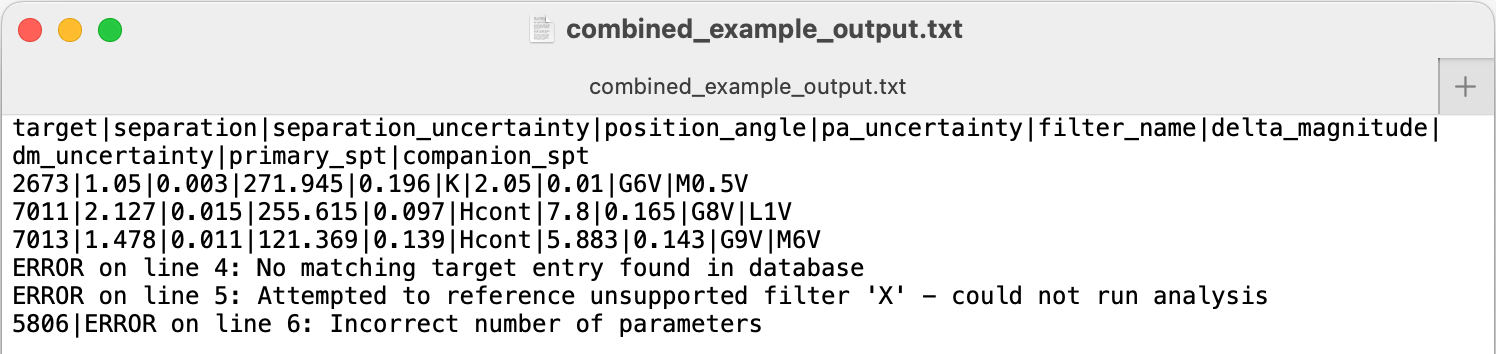